In [1]:
import colorsys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2


import numpy as np
from PIL import Image
from keras import backend as K
from keras.models import load_model
from keras.layers import Input

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import image_preporcess

class YOLO(object):
    _defaults = {
        "model_path": 'logs/trained_weights_final.h5',
        #"model_path": 'model_data/yolo_weights.h5',
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": '1_CLASS_train_classes.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "text_size" : 3,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))

        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = image_preporcess(np.copy(image), tuple(reversed(self.model_image_size)))
            image_data = boxed_image

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.shape[0], image.shape[1]],#[image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        #print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        thickness = (image.shape[0] + image.shape[1]) // 600
        fontScale=1
        ObjectsList = []
        
        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            #label = '{}'.format(predicted_class)
            scores = '{:.2f}'.format(score)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.shape[0], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.shape[1], np.floor(right + 0.5).astype('int32'))

            mid_h = (bottom-top)/2+top
            mid_v = (right-left)/2+left

            # put object rectangle
            cv2.rectangle(image, (left, top), (right, bottom), self.colors[c], thickness)

            # get text size
            (test_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, thickness/self.text_size, 1)

            # put text rectangle
            cv2.rectangle(image, (left, top), (left + test_width, top - text_height - baseline), self.colors[c], thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (left, top-2), cv2.FONT_HERSHEY_SIMPLEX, thickness/self.text_size, (0, 0, 0), 1)

            # add everything to list
            ObjectsList.append([top, left, bottom, right, mid_v, mid_h, label, scores])

        return image, ObjectsList

    def close_session(self):
        self.sess.close()

    def detect_img(self, image):
        image = cv2.imread(image, cv2.IMREAD_COLOR)
        original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_image_color = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        
        r_image, ObjectsList = self.detect_image(original_image_color)
        return r_image, ObjectsList

    

yolo = YOLO()
image = '00511.jpg'
r_image, ObjectsList = yolo.detect_img(image)
#print(ObjectsList)
#cv2.imshow(image, r_image)
yolo.close_session()

C:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.
C:\Users\Miron\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Miron\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 

Instructions for updating:
Colocations handled automatically by placer.
logs/trained_weights_final.h5 model, anchors, and classes loaded.


In [4]:
import keras

In [2]:
ObjectsList

[]

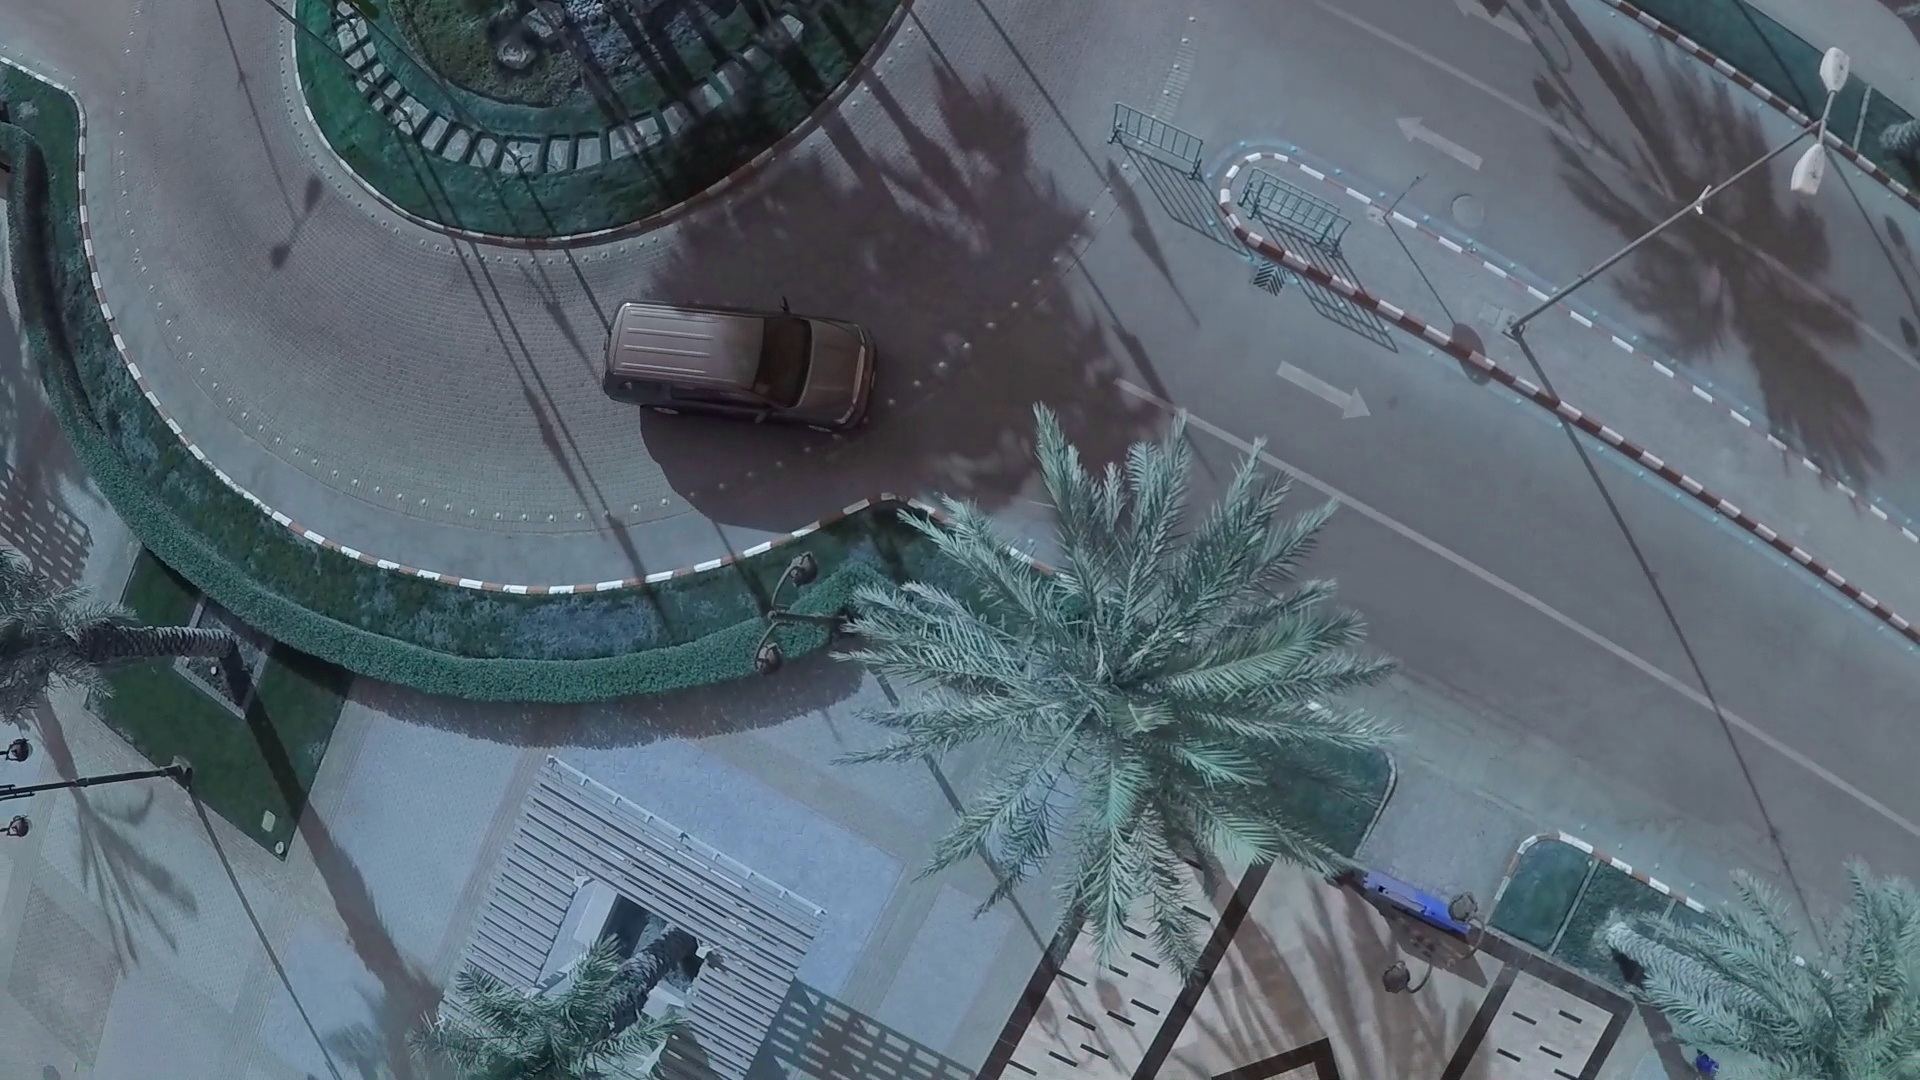

In [3]:
r_image_ = Image.fromarray(r_image)
r_image_